In [1]:
import mujoco
from mujoco import minimize
import numpy as np
from pathlib import Path
import mediapy as media
import gym_lite6
# np.set_printoptions(precision=3, suppress=True, linewidth=100)


pygame 2.2.0 (SDL 2.30.2, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [13]:
# Load model XML
MODEL_DIR = (Path(gym_lite6.__path__[0]).parent/"models").resolve()
print(MODEL_DIR)
model_path = MODEL_DIR/"lite6_gripper.xml"
model = mujoco.MjModel.from_xml_path(str(model_path))
data = mujoco.MjData(model)
ik_data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

/Users/Eugene/Developer/robotic_manipulation/gym_lite6/models


""

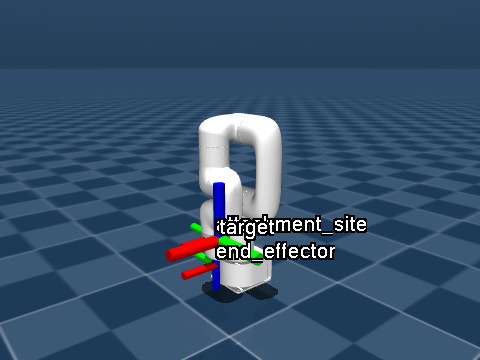

In [14]:
# Initial model visualisation and parameter setup
mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)

# Make a Renderer and a camera.
renderer = mujoco.Renderer(model, height=360, width=480)
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.2
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)

# Visualize site frames and labels
voption = mujoco.MjvOption()
voption.frame = mujoco.mjtFrame.mjFRAME_SITE
voption.label = mujoco.mjtLabel.mjLABEL_SITE
renderer.update_scene(data, camera, scene_option=voption)
voption.label = mujoco.mjtLabel.mjLABEL_NONE

media.show_image(renderer.render())


""

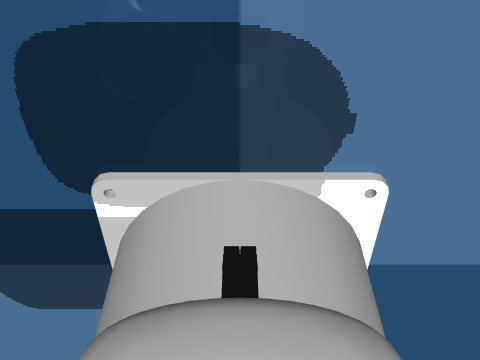

In [15]:
renderer.update_scene(data, camera='gripper_cam')
# renderer.update_scene(data, camera='side_cam')
media.show_image(renderer.render())


In [39]:
# Stereo rendering test - PITA
scene=mujoco.MjvScene(model, maxgeom=20)
scene.stereo=1
# renderer.update_scene(data, camera='gripper_cam', scene=scene)
mujoco.mjv_updateScene(model, data, mujoco.MjvOption(), None, camera, mujoco.mjtCatBit(1+2+4), scene)
mujoco.mjr_render()

TypeError: mjr_render(): incompatible function arguments. The following argument types are supported:
    1. (viewport: mujoco._render.MjrRect, scn: mujoco._structs.MjvScene, con: mujoco._render.MjrContext) -> None

Invoked with: 

In [229]:
def ik(x, pos, quat, radius=0.04, reg=1e-3, reg_target=None, ref_frame='end_effector'):
    """Residual for inverse kinematics.

    Args:
        x: numpy column vector of joint angles.
        pos: target position for the end effector.
        quat: target orientation for the end effector.
        radius: scaling of the 3D cross.

    Returns:
        The residual of the Inverse Kinematics task.
    """

    # Move the mocap body to the target
    id = model.body('target').mocapid
    ik_data.mocap_pos[id] =  pos
    ik_data.mocap_quat[id] = quat

    res = []
    # For batched operation, each column can be a different x
    for i in range(x.shape[1]):
        # Forward kinematics for given state
        ik_data.qpos[:6] = x[:, i]
        mujoco.mj_kinematics(model, ik_data)

        # Position residual
        res_pos = ik_data.site(ref_frame).xpos - ik_data.site('target').xpos
        # print(ik_data.site(ref_frame).xpos)
        
        # Get the ref frame orientation (convert from rotation matrix to quaternion)
        ref_quat = np.empty(4)
        mujoco.mju_mat2Quat(ref_quat, ik_data.site(ref_frame).xmat)

        # Target quat, exploit the fact that the site is aligned with the body.
        target_quat = ik_data.body('target').xquat

        # Orientation residual: quaternion difference.
        res_quat = np.empty(3)
        mujoco.mju_subQuat(res_quat, target_quat, ref_quat)
        res_quat *= radius

        res_reg = reg * (x[:, i] - reg_target)
        
        res_i = np.hstack((res_pos, res_quat, res_reg))
        res.append(np.atleast_2d(res_i).T)
    
    return np.hstack(res)

def ik_jac(x, res=None, radius=0.04, reg=1e-3, ref_frame='end_effector'):
    """Analytic Jacobian of inverse kinematics residual

    Args:
        x: joint angles.
        res: least_squares() passes the value of the residual at x which is sometimes useful, but we don't need it here.
        radius: scaling of the 3D cross.

    Returns:
        The Jacobian of the Inverse Kinematics task.
        (3 + 3 + nv)  * nv
    """
    mujoco.mj_kinematics(model, ik_data)
    mujoco.mj_comPos(model, ik_data) #calculate CoM position

    # Get end-effector site Jacobian.
    jac_pos = np.empty((3, model.nv))
    jac_quat = np.empty((3, model.nv))
    mujoco.mj_jacSite(model, ik_data, jac_pos, jac_quat, ik_data.site(ref_frame).id)
    jac_pos = jac_pos[:, :6]
    jac_quat = jac_quat[:, :6]

    # Get the ref frame orientation (convert from rotation matrix to quaternion)
    ref_quat = np.empty(4)
    mujoco.mju_mat2Quat(ref_quat, ik_data.site(ref_frame).xmat)
    
    # Get Deffector, the 3x3 Jacobian for the orientation difference
    target_quat = ik_data.body('target').xquat
    Deffector = np.empty((3, 3))
    mujoco.mjd_subQuat(target_quat, ref_quat, None, Deffector)

    # Rotate into target frame, multiply by subQuat Jacobian, scale by radius.
    target_mat = ik_data.site('target').xmat.reshape(3, 3)
    mat =  Deffector.T @ target_mat.T
    jac_quat = radius * mat @ jac_quat

    # Regularization Jacobian
    jac_reg = reg * np.eye(6)

    return np.vstack((jac_pos, jac_quat, jac_reg))

In [328]:
def pose_faceout(time, speed=1, init_quat=np.array((np.sqrt(2)/2, 0, np.sqrt(2)/2, 0))):
  """
  Rotate around the origin, move up and down, keep end effector facing outwards
  Args:
    time: time in seconds at which to calculate the pose
    speed: a factor by which to speed up the motion (or slow it down)
    init_quat: an initial rotation. The default gets z of the end effector facing outwards
  """

  pos = np.array((0.4 * np.sin(speed*time),
         0.4 * np.cos(speed*time),
         0.35 + 0.1 * np.sin(3 * speed*time)))
  # Angle around z axis
  theta = np.arctan2(pos[1], pos[0])
  # Convert to quaternion
  quat = np.array((np.cos(theta/2), 0, 0, np.sin(theta/2)))
  quat /= np.linalg.norm(quat)

  res_quat = np.zeros(4)
  mujoco.mju_mulQuat(res_quat, quat, init_quat)

  return pos, res_quat

def disable_actuator_group(model, group_id):
  model.opt.disableactuator = 2**group_id

In [346]:
# Position control

# Disable group 2
disable_actuator_group(model, 2)
# disable_actuator_group(model, 1)


DURATION = 2          # seconds
FRAMERATE = 60        # Hz
frames = []
x0 = np.array([1.546, 0.541, 1.49 , 2.961, 0.596, 0.203])
x = x0
mujoco.mj_resetData(model, data)
# mujoco.mj_resetData(model, ik_data)
data.qpos[:6] = x0

while data.time < DURATION:
  # Move the target
  # pos, quat = pose(data.time, speed=1)
  pos, quat = pose_faceout(data.time, speed=1)

  x_prev = x.copy()

  # Define IK problem
  ik_target = lambda x: ik(x, pos=pos, quat=quat,
                           reg_target=x_prev, radius=0.5, reg=.1)

  x, _ = minimize.least_squares(x, ik_target, (model.jnt_range[:6, 0], model.jnt_range[:6, 1]),
                                jacobian=ik_jac,
                                verbose=0)
  
  data.ctrl[:6] = x
  id = model.body('target').mocapid
  data.mocap_pos[id] =  pos
  data.mocap_quat[id] = quat
  # data.ctrl[7:13] = x

  # mujoco.mj_camlight(model, data)
  mujoco.mj_step(model, data)
  # mujoco.mj_kinematics(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())

media.show_video(frames, loop=False)

In [269]:
# Velocity control
disable_actuator_group(model, 1)

DURATION = 3          # seconds
FRAMERATE = 60        # Hz
frames = []
x0 = np.array([1.546, 0.541, 1.49 , 2.961, 0.596, 0.203])
x = x0
mujoco.mj_resetData(model, data)
# mujoco.mj_resetData(model, ik_data)
data.qpos[:6] = x0
# data.act = x0
mujoco.mj_forward(model, data)

site_id = model.site('end_effector').id
target_mocapid = model.body('target').mocapid

jac = np.zeros((6, model.nv))
twist = np.empty(6)
error = np.zeros(6)
curr_quat = np.empty(4)
curr_quat_conj = np.empty(4)
quat_err = np.empty(4)
dq = np.zeros(6)

while data.time < DURATION:
  # Move the target
  # pos, quat = pose(data.time, speed=1)
  target_pos, target_quat = pose_faceout(data.time, speed=1)

  error[:3] = target_pos - data.site(site_id).xpos

  # Quat error
  mujoco.mju_mat2Quat(curr_quat, data.site(site_id).xmat)
  mujoco.mju_negQuat(curr_quat_conj, curr_quat)
  mujoco.mju_mulQuat(quat_err, target_quat, curr_quat_conj)
  mujoco.mju_quat2Vel(error[3:], quat_err, 1.0)
  # print(error)

  # Get end-effector site Jacobian.
  mujoco.mj_jacSite(model, data, jac[:3, :], jac[3:, :], site_id)
  jac_arm = jac[:, :6]

  diag = 1e-4 * np.eye(6)
  # Solve system of equations: J @ dq = error.
  dq = jac_arm.T @ np.linalg.solve(jac_arm @ jac_arm.T + diag, error)
  
  # print(dq)
  q = data.qpos.copy()
  # mujoco.mj_integratePos(model, q, dq, 0.1)
  data.ctrl[6:12] = dq*30
  # data.qvel[:6] = dq*20
  # data.qpos[:6] += dq

  data.mocap_pos[target_mocapid] = target_pos
  data.mocap_quat[target_mocapid] = target_quat

  # print(data.act)

  mujoco.mj_step(model, data)
  
  # mujoco.mj_kinematics(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())

media.show_video(frames, loop=False)

""

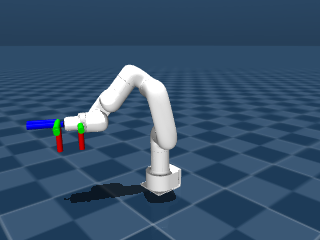

In [347]:
data.qpos[:6] = np.array([-1.34910271e-01,  1.26251503e+00,  1.87041314e+00, -2.61714269e-06,
  6.07893155e-01,  6.14828583e+00])
mujoco.mj_forward(model, data)
media.show_image(renderer.render())


In [348]:
disable_actuator_group(model, 2)

print(pos)
ik_target = lambda x: ik(x, pos=pos, quat=quat,
                          reg_target=x_prev, radius=0.5, reg=.1)

x, _ = minimize.least_squares(x, ik_target, (model.jnt_range[:6, 0], model.jnt_range[:6, 1]),
                              jacobian=ik_jac,
                              verbose=0)

# data.ctrl[:6] = x
data.qpos[:6] = x
mujoco.mj_forward(model, data)
print(data.site('end_effector').xpos)

[ 0.36405116 -0.16573096  0.32148285]
[ 0.36405166 -0.16572967  0.32148133]


In [240]:
print(pos)
ik_target = lambda x: ik(x, pos=pos, quat=quat,
                          reg_target=x_prev, radius=0.5, reg=.1)

x, _ = minimize.least_squares(x, ik_target, (model.jnt_range[:6, 0], model.jnt_range[:6, 1]),
                              jacobian=ik_jac,
                              verbose=0)

# data.ctrl[:6] = x
data.qpos[:6] = x
mujoco.mj_step(model, data)
print(data.site('end_effector').xpos)

[ 0.36405116 -0.16573096  0.32148285]
[ 0.36405193 -0.16572907  0.32148133]


Final error: 
[ 3.15818482e-11 -3.61115319e-03  2.97929010e-03 -1.28127157e-04
  2.05723801e-04 -1.23700966e-06]
[-0.01225374  0.00334133  0.00100239]
[ 0.0072749  -0.00126893 -0.00413089]
Goal pos:
[1.52007338 0.13493514 0.96122388 3.060549   0.7456582  0.06040274]
[0.   0.4  0.35] [ 0.5 -0.5  0.5  0.5]


""

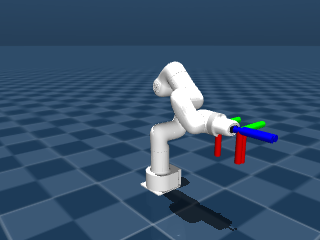

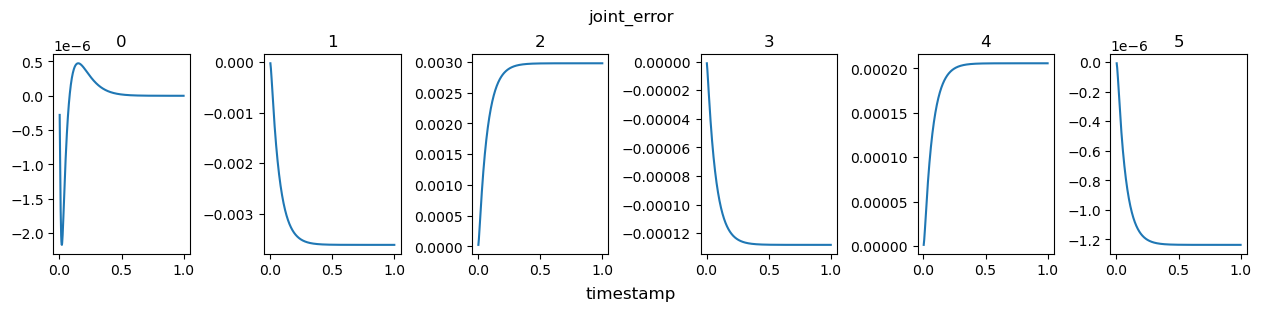

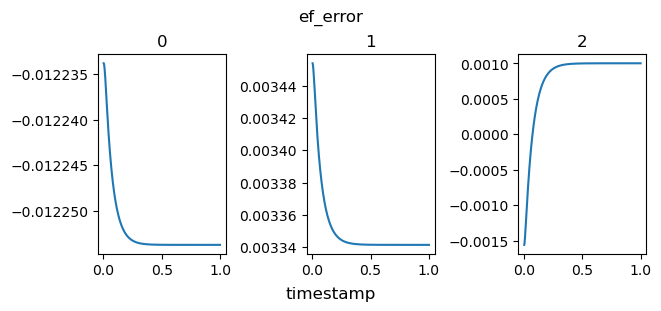

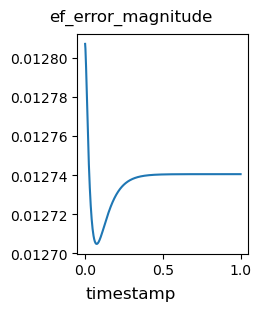

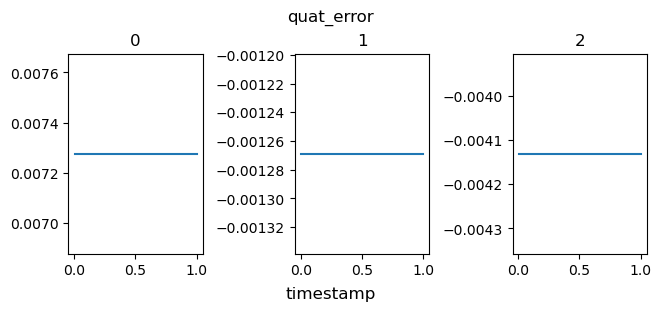

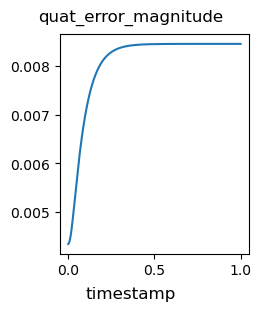

In [373]:
from gym_lite6.utils import plot_dict_of_arrays
from importlib import reload
reload(gym_lite6.utils)

model.opt.gravity = np.array([0, 0, -9.81])
# model.opt.gravity = np.array([0, 0, 0])


disable_actuator_group(model, 2)

mujoco.mj_resetData(model, data)
pos, quat = pose_faceout(0.0, speed=1)
# pos = data.site('end_effector').xpos
# quat = np.empty(4)
x_prev = np.zeros(6)
x = x_prev

# Solve initial position
for i in range(4):
  ik_target = lambda x: ik(x, pos=pos, quat=quat,
                              reg_target=x_prev, radius=1, reg=0.1)

  ik_jac_target = lambda x, res: ik_jac(x, radius=1, reg=0.1)

  x, _ = minimize.least_squares(x, ik_target, (model.jnt_range[:6, 0], model.jnt_range[:6, 1]),
                                jacobian=ik_jac_target,
                                verbose=0)
  x_prev = x

id = model.body('target').mocapid
data.mocap_pos[id] =  pos
data.mocap_quat[id] = quat
data.qpos[:6] = x
data.ctrl[:6] = x
mujoco.mj_forward(model, data)

ep_dict = {"joint_error": [], "ef_error": [], "timestamp": [], "ef_error_magnitude": [], "quat_error": [], "quat_error_magnitude": []}

curr_quat = np.empty(4)
curr_quat_conj = np.empty(4)
quat_err = np.empty(4)
quat_err_xyz = np.empty(3)

for i in range(500):
  
  data.ctrl[:6] = x
  mujoco.mj_step(model, data)

  # Quat error
  mujoco.mju_mat2Quat(curr_quat, data.site("end_effector").xmat)
  mujoco.mju_negQuat(curr_quat_conj, curr_quat)
  mujoco.mju_mulQuat(quat_err, target_quat, curr_quat_conj)
  mujoco.mju_quat2Vel(quat_err_xyz, quat_err, 1.0)

  ep_dict["joint_error"].append(x - data.qpos[:6])
  ep_dict["ef_error"].append(pos - data.site('end_effector').xpos)
  ep_dict["timestamp"].append(data.time)
  ep_dict["ef_error_magnitude"].append(np.linalg.norm(ep_dict["ef_error"][-1]))
  ep_dict["quat_error"].append(quat_err_xyz)
  ep_dict["quat_error_magnitude"].append(np.linalg.norm(quat_err_xyz))

  

gym_lite6.utils.plot_dict_of_arrays(ep_dict, "timestamp", sharey=False)
print("Final error: ")
print(ep_dict["joint_error"][-1])
print(ep_dict["ef_error"][-1])
print(ep_dict["quat_error"][-1])

print("Goal pos:")
print(x)
print(pos, quat)
renderer.update_scene(data, camera, scene_option=voption)
media.show_image(renderer.render())

In [374]:
data.qfrc_bias

array([-1.70346317e-17, -7.22231007e+00,  5.95858365e+00, -2.56254479e-01,
        4.11447786e-01, -2.47402024e-03,  6.38579746e-05,  6.38579259e-05])

: 